## HW3

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jsonlines
from typing import Dict, List
from pprint import pprint
from tqdm import tqdm
import torch
import os
import numpy as np
import pandas as pd
from torch import Tensor
from collections import defaultdict
import transformers
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from transformers import BertTokenizer, BertModel, BertForSequenceClassification
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, RandomSampler
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import fbeta_score
from collections import namedtuple

In [3]:
# Опеределяем device на котором будет производиться обуение
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
device = torch.device('cuda')

In [4]:
# Оперделяем torch.Dataset для получения токенизированых данных 
# с масками для классификации в формате который ожидает transfromers BertModel
BertDatasetResult = namedtuple(
    'BertDatasetResult',
    [
        'text',
        'label'
    ]
)


class BertDataset(Dataset):
    def __init__(
            self,
            data: List[Dict[str, str]],
            pretrained_name: str = "DeepPavlov/rubert-base-cased-sentence",
            tensor_labels=False,
            label_flag=True
    ):
        self.label_flag = label_flag
        self.tokenizer = BertTokenizer.from_pretrained(pretrained_name)
        self.original_data = data
        self.data = list(map(self.prepare_row, data))
        self.device = 'cuda'
        self.tensor_labels = tensor_labels

    def prepare_row(self, row):
        return {
            'text': self.tokenizer.encode_plus(
                # row['premise'] + self.tokenizer.sep_token + row['hypothesis'],
                row['premise'], row['hypothesis'],
                padding='max_length',
                truncation=True,
                max_length=256
            ),
            'label': row['label'] if self.label_flag else 0,
        }

    def __getitem__(self, idx):
        current = self.data[idx]
        return BertDatasetResult(
            text={
                'input_ids': torch.LongTensor(current['text']['input_ids']).to(self.device),
                'attention_mask': torch.LongTensor(current['text']['attention_mask']).to(self.device),
                'token_type_ids': torch.LongTensor(current['text']['token_type_ids']).to(self.device)
            },
            label=torch.LongTensor(
                [current['label']]
            ).squeeze(0).to(self.device) if self.tensor_labels else current['label']
        )

    def __len__(self):
        return len(self.data)


In [5]:
# Вспомагительыне функции
def read_data(data_path: str) -> List[Dict[str, str]]:
    with jsonlines.open(data_path) as reader:
        return [line for line in reader]


def get_embeddings(model: BertModel, dataloader):
    labels = []
    for i, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        embedded_batch = model(**batch.text).pooler_output.cpu().detach().numpy()
        if i == 0:
            embedded = embedded_batch.copy()
        else:
            embedded = np.vstack((embedded, embedded_batch))
        labels += batch.label
    return embedded, labels


def get_predictions(model: BertModel, dataloader):
    for batch in dataloader:
        pass

**Part 0. [1 point] Get embeddings**

Take any BERT model (for example any from DeepPavlov Ruberts) and get BERT embeddings from the train dataset (or train + dev).

In [6]:
!ls -la data

total 4464
drwxr-xr-x 3 s.filimonov s.filimonov    4096 Apr 15 16:23 .
drwxrwxr-x 8 s.filimonov s.filimonov    4096 Apr 25 19:38 ..
drwxrwxr-x 2 s.filimonov s.filimonov    4096 Apr 15 16:23 .ipynb_checkpoints
-rw-r--r-- 1 s.filimonov s.filimonov  980211 Apr 14 20:29 mipt-nlp-hw3-2021.zip
-rw-r--r-- 1 s.filimonov s.filimonov 1810454 Apr 14 20:29 test.jsonl
-rw-r--r-- 1 s.filimonov s.filimonov 1553715 Apr 14 20:29 train.jsonl
-rw-r--r-- 1 s.filimonov s.filimonov  178095 Apr 14 20:29 val.jsonl


In [7]:
train_data = read_data('data/train.jsonl')
valid_data = read_data('data/val.jsonl')
test_data = read_data('data/test.jsonl')

In [8]:
train_dataset = BertDataset(train_data)
valid_dataset = BertDataset(valid_data)
train_loader = DataLoader(train_dataset, batch_size = 4, shuffle = False)
valid_loader = DataLoader(valid_dataset, batch_size = 4, shuffle = False)

In [9]:
valid_data[0]

{'premise': '"""Решение носит символический характер, так как взыскать компенсацию практически невозможно"", - отмечается в сообщении."',
 'hypothesis': 'Взыскать компенсацию не получится.',
 'label': 'entailment',
 'idx': 0}

In [10]:
# Опеределим предобученный ruBERT и даталоадер
pretrained_name = "DeepPavlov/rubert-base-cased-sentence"
model = BertModel.from_pretrained(pretrained_name)
model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
         

In [19]:
# Получим эмбединги
embedded, labels = get_embeddings(model, train_loader)

100%|██████████| 654/654 [01:42<00:00,  6.38it/s]


**Part 1. [2 point] Explore your data**
Make a 2D reduction and draw plot for train labels.
Analyze your results.

In [21]:
from tsnecuda import TSNE
import faiss
from sklearn.preprocessing import StandardScaler

In [ ]:
lables_for_visualization = []
for row in labels:
    if row == 'entailment':
        lables_for_visualization.append(1)
    else:
        lables_for_visualization.append(0)

In [22]:
tsne = TSNE(n_components=2, verbose=5)
word_vectors_tsne = tsne.fit_transform(np.array(embedded))

In [23]:
ss = StandardScaler().fit(word_vectors_tsne)
word_vectors_tsne = ss.transform(word_vectors_tsne)

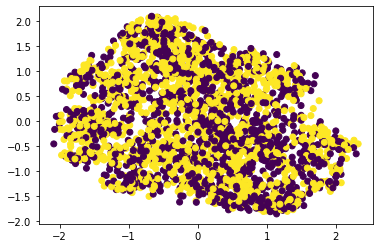

In [24]:
plt.scatter(word_vectors_tsne[:, 0], word_vectors_tsne[:, 1], c = lables_for_visualization)
plt.show()

In [25]:
# Как видно, по получившимся эмбеддингам 
# невоозможно отделить кластеры по лейблам

**Part 2. [3 points] Make first classifier**
Use pretrained embeddings as features to classifier. You can use for example SVM or LinearRegression.
Make crossvalidation and describe your results.

In [28]:
# Для получения предсказаний возьмем BertForSequenceClassification из transformers
# c линейным бинарным классификатором после слоя пулинга

In [40]:
model = BertForSequenceClassification.from_pretrained(pretrained_name)
model.to(device)
print('Ok')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-sentence and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Ok


In [9]:
# Перевод текстовых лейблов к целочисленным
for row in train_data:
    if row['label'] == 'entailment':
        row['label'] = 1
    else:
        row['label'] = 0
for row in valid_data:
    if row['label'] == 'entailment':
        row['label'] = 1
    else:
        row['label'] = 0

In [57]:
predictions = []
model.eval()
for batch in tqdm(valid_loader):
    current_preds = torch.argmax(model(**batch.text).logits, dim=1).tolist()
    predictions += current_preds

100%|██████████| 77/77 [00:12<00:00,  6.33it/s]


In [58]:
labels_for_metric = [i['label'] for i in valid_data]

In [8]:
from sklearn.metrics import accuracy_score, fbeta_score, f1_score

In [60]:
acc_score = accuracy_score(labels_for_metric, predictions)
f1_macro_score = fbeta_score(labels_for_metric, predictions, beta=1.0, average='macro')
f05_macro_score = fbeta_score(labels_for_metric, predictions, beta=0.5, average='macro')
f2_macro_score = fbeta_score(labels_for_metric, predictions, beta=2.0, average='macro')
print(f'Acc: {acc_score}, f1: {f1_macro_score}, f05: {f05_macro_score}, f2: {f2_macro_score}')

Acc: 0.4560260586319218, f1: 0.3855069337072861, f05: 0.38551597858337766, f2: 0.41734581936095627


In [62]:
all_not_entailment = [0 for _ in valid_data]
acc_score = accuracy_score(all_not_entailment, predictions)
f1_macro_score = fbeta_score(all_not_entailment, predictions, beta=1.0, average='macro')
f05_macro_score = fbeta_score(all_not_entailment, predictions, beta=0.5, average='macro')
f2_macro_score = fbeta_score(all_not_entailment, predictions, beta=2.0, average='macro')
print(f'Acc: {acc_score}, f1: {f1_macro_score}, f05: {f05_macro_score}, f2: {f2_macro_score}')

Acc: 0.8371335504885994, f1: 0.45567375886524825, f05: 0.48127340823970044, f2: 0.43265993265993274


/home/care1e55/.local/lib/python3.8/site-packages/sklearn/metrics/classification.py:1438: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  recall = _prf_divide(tp_sum, true_sum,


In [54]:
# Видим качество предсказания хуже чем предсказывать все 0

**Part 3. [4 points] Finetune on Classification task**
Finetune on a classification task with BERT-based model you chose in the 0 part (Example of code see here)
Submit your results and get scores for your models. https://www.kaggle.com/c/mipt-nlp-hw3-2021

In [11]:
train_dataset = BertDataset(train_data)
valid_dataset = BertDataset(valid_data)

In [12]:
# # Перед текстовых лейблов к целочисленным
for row in train_data:
    if row['label'] == 'entailment':
        row['label'] = 1
    else:
        row['label'] = 0
for row in valid_data:
    if row['label'] == 'entailment':
        row['label'] = 1
    else:
        row['label'] = 0

In [13]:
train_loader = DataLoader(train_dataset, batch_size = 4, shuffle = True)
valid_loader = DataLoader(valid_dataset, batch_size = 4, shuffle = True)

In [14]:
# Оперделим свою мадель на основе той что есть в transformers с небольшими отличиями

In [15]:
import torch.nn as nn
from transformers import AutoConfig, AutoModel


class BertForSequenceClassification(nn.Module):
    """
    Simplified version of the same class by HuggingFace.
    See transformers/modeling_distilbert.py in the transformers repository.
    """
    def __init__(
        self, pretrained_model_name: str, num_classes: int = None, dropout: float = 0.3
    ):
        """
        Args:
            pretrained_model_name (str): HuggingFace model name.
                See transformers/modeling_auto.py
            num_classes (int): the number of class labels
                in the classification task
        """
        super().__init__()
        config = AutoConfig.from_pretrained(
            pretrained_model_name, num_labels=num_classes
        )
        self.model = AutoModel.from_pretrained(pretrained_model_name, config=config)
        self.classifier = nn.Linear(config.hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids, attention_mask=None, token_type_ids = None, head_mask=None):
        """Compute class probabilities for the input sequence.
        Args:
            features (torch.Tensor): ids of each token,
                size ([bs, seq_length]
            attention_mask (torch.Tensor): binary tensor, used to select
                tokens which are used to compute attention scores
                in the self-attention heads, size [bs, seq_length]
            head_mask (torch.Tensor): 1.0 in head_mask indicates that
                we keep the head, size: [num_heads]
                or [num_hidden_layers x num_heads]
        Returns:
            PyTorch Tensor with predicted class scores
        """
        assert attention_mask is not None, "attention mask is none"
        bert_output = self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            head_mask=head_mask
        )
        seq_output = bert_output[0]  # (bs, seq_len, dim)
        pooled_output = seq_output.mean(axis=1)  # (bs, dim)
        pooled_output = self.dropout(pooled_output)  # (bs, dim)
        scores = self.classifier(pooled_output)  # (bs, num_classes)
        return scores


In [16]:
# Оперделим класс для обучения
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import fbeta_score
import warnings

warnings.filterwarnings("ignore")

class ClassTrainer():
    def __init__(self):
        self.params = {
            'lr': 0.00002,
            'epochs': 10,
            'pretrained_name': "DeepPavlov/rubert-base-cased-sentence"
        }

        self.dataloaders = self.initialize_dataloaders(4)
        self.model = BertForSequenceClassification(self.params['pretrained_name'], num_classes=2)
        self.model.to(device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), self.params['lr'])
        self.scheduler = StepLR(self.optimizer, step_size=2, gamma=0.5)
        self.criterion = nn.CrossEntropyLoss().to(device)

    def label_to_class(self, data):
        for row in data:
            if row['label'] == 'entailment':
                row['label'] = 1
            else:
                row['label'] = 0

    def make_test_submission(self, model):
        test_predictions = []
        test_dataloader = self.dataloaders['test']
        for batch in tqdm(test_dataloader, total=len(test_dataloader)):
            predictions = model(**batch.text)
            test_predictions += [pred[0] for pred in predictions.argmax(1, keepdim=True).detach().cpu().tolist()]

    def initialize_dataloaders(self, batch_size=4):
        train_data = read_data('data/train.jsonl')
        valid_data = read_data('data/val.jsonl')
        test_data = read_data('data/test.jsonl')
        self.label_to_class(train_data)
        self.label_to_class(valid_data)
        return {
            'train': DataLoader(
                BertDataset(train_data, tensor_labels=True),
                batch_size,
                shuffle=True
            ),
            'valid': DataLoader(
                BertDataset(valid_data, tensor_labels=True),
                batch_size,
                shuffle=True
            ),
            'test': DataLoader(
                BertDataset(test_data, tensor_labels=False, label_flag=False),
                batch_size,
                shuffle=False
            ),

        }

    def train(self):
        params = self.params
        print('Current prams', params)
        best_eval_metric = 0
        for epoch in range(params['epochs']):
            self.train_epoch(epoch)
            curr_eval_metric = self.eval_epoch(epoch)
            if curr_eval_metric > best_eval_metric:
                best_eval_metric = curr_eval_metric
                torch.save(self.model.state_dict(), 'best.model')
            self.scheduler.step()
        return best_eval_metric

    def train_epoch(self, epoch):
        self.model.train()
        epoch_loss = 0
        epoch_acc = 0
        epoch_f1 = 0
        epoch_f05 = 0
        length = len(self.dataloaders['train'])
        for batch in tqdm(self.dataloaders['train']):
            self.optimizer.zero_grad()
            predictions = self.model(**batch.text)
            loss = self.criterion(predictions, batch.label)
            loss.backward()
            self.optimizer.step()
            epoch_loss += loss
            epoch_acc += self.categorical_accuracy(predictions, batch.label)
            y_pred = [pred[0] for pred in predictions.argmax(1, keepdim=True).detach().cpu().tolist()]
            y_true = batch.label.detach().cpu().tolist()
            epoch_f1 += fbeta_score(y_true, y_pred, 1, average='macro')
            epoch_f05 += fbeta_score(y_true, y_pred, 0.5, average='macro')
        print(f'''
            Train Epoch: {epoch}, 
            loss: {epoch_loss / length}, 
            Acc: {epoch_acc / length},
            F1: {epoch_f1 / length},
            F0.5: {epoch_f05 / length},
        ''')

    def eval_epoch(self, epoch):
        self.model.eval()
        eval_epoch_loss = 0
        eval_epoch_acc = 0
        eval_epoch_f1 = 0
        eval_epoch_f05 = 0
        length = len(self.dataloaders['valid'])
        for batch in tqdm(self.dataloaders['valid']):
            predictions = self.model(**batch.text).detach()
            loss = self.criterion(predictions, batch.label.detach()).detach()
            eval_epoch_loss += loss.cpu()
            eval_epoch_acc += self.categorical_accuracy(predictions, batch.label.detach()).detach().cpu()
            y_pred = [pred[0] for pred in predictions.argmax(1, keepdim=True).detach().cpu().tolist()]
            y_true = batch.label.detach().cpu().tolist()
            eval_epoch_f1 += fbeta_score(y_true, y_pred, 1, average='macro')
            eval_epoch_f05 += fbeta_score(y_true, y_pred, 0.5, average='macro')
        print(f'''
            Eval Epoch: {epoch}, 
            loss: {eval_epoch_loss / length}, 
            Acc: {eval_epoch_acc / length},
            F1: {eval_epoch_f1 / length},
            F0.5: {eval_epoch_f05 / length},
        ''')
        return eval_epoch_f1 / length

    def categorical_accuracy(self, preds, y):
        top_pred = preds.argmax(1, keepdim=True)
        correct = top_pred.eq(y.view_as(top_pred)).sum()
        acc = correct.float() / y.shape[0]
        return acc

In [16]:
# Запустим обученeе
trainer = ClassTrainer()
trainer.train()

  0%|          | 1/654 [00:00<01:45,  6.21it/s]

Current prams {'lr': 2e-05, 'epochs': 10, 'pretrained_name': 'DeepPavlov/rubert-base-cased-sentence'}


  6%|▋         | 5/77 [00:00<00:01, 43.56it/s]


            Train Epoch: 0, 
            loss: 0.7158905863761902, 
            Acc: 0.5252293944358826,
            F1: 0.4261103829911152,
            F0.5: 0.42088817601011397,
        


100%|██████████| 77/77 [00:01<00:00, 42.44it/s]



            Eval Epoch: 0, 
            loss: 0.6360751986503601, 
            Acc: 0.6450216770172119,
            F1: 0.5666048237476813,
            F0.5: 0.5704289642938069,
        


  6%|▋         | 5/77 [00:00<00:01, 42.97it/s]


            Train Epoch: 1, 
            loss: 0.6169688701629639, 
            Acc: 0.6655198931694031,
            F1: 0.5858380661132943,
            F0.5: 0.5917006464371851,
        


100%|██████████| 77/77 [00:01<00:00, 43.05it/s]



            Eval Epoch: 1, 
            loss: 0.6382334232330322, 
            Acc: 0.6558441519737244,
            F1: 0.5988249845392706,
            F0.5: 0.614141764545347,
        


  6%|▋         | 5/77 [00:00<00:01, 41.98it/s]


            Train Epoch: 2, 
            loss: 0.32751837372779846, 
            Acc: 0.863914430141449,
            F1: 0.8217707878258351,
            F0.5: 0.8298414449561579,
        


100%|██████████| 77/77 [00:01<00:00, 43.26it/s]



            Eval Epoch: 2, 
            loss: 0.9045296311378479, 
            Acc: 0.6580086946487427,
            F1: 0.6000618429189861,
            F0.5: 0.6143881679382366,
        


  6%|▋         | 5/77 [00:00<00:01, 43.43it/s]


            Train Epoch: 3, 
            loss: 0.13857802748680115, 
            Acc: 0.947629988193512,
            F1: 0.9319207805446351,
            F0.5: 0.9343530949865438,
        


100%|██████████| 77/77 [00:01<00:00, 43.41it/s]



            Eval Epoch: 3, 
            loss: 1.0980257987976074, 
            Acc: 0.6601731181144714,
            F1: 0.5907544836116266,
            F0.5: 0.5968513258517179,
        


  6%|▋         | 5/77 [00:00<00:01, 43.17it/s]


            Train Epoch: 4, 
            loss: 0.052953656762838364, 
            Acc: 0.9827982187271118,
            F1: 0.9751274209989813,
            F0.5: 0.9759857940537559,
        


100%|██████████| 77/77 [00:01<00:00, 43.36it/s]



            Eval Epoch: 4, 
            loss: 1.4147247076034546, 
            Acc: 0.6580086946487427,
            F1: 0.5996907854050714,
            F0.5: 0.6121082238284503,
        


  6%|▋         | 5/77 [00:00<00:01, 43.47it/s]


            Train Epoch: 5, 
            loss: 0.028719265013933182, 
            Acc: 0.9912079572677612,
            F1: 0.9882918304936658,
            F0.5: 0.9889294769334601,
        


100%|██████████| 77/77 [00:01<00:00, 43.43it/s]



            Eval Epoch: 5, 
            loss: 1.5836536884307861, 
            Acc: 0.6341991424560547,
            F1: 0.5553803339517626,
            F0.5: 0.5653359527525224,
        


  6%|▋         | 5/77 [00:00<00:01, 42.19it/s]


            Train Epoch: 6, 
            loss: 0.012668526731431484, 
            Acc: 0.9946483373641968,
            F1: 0.9919615552643077,
            F0.5: 0.9922822292676832,
        


100%|██████████| 77/77 [00:01<00:00, 43.38it/s]



            Eval Epoch: 6, 
            loss: 1.8714373111724854, 
            Acc: 0.6417748928070068,
            F1: 0.5529375386518246,
            F0.5: 0.5578891454698116,
        


  6%|▋         | 5/77 [00:00<00:01, 43.02it/s]


            Train Epoch: 7, 
            loss: 0.009448322467505932, 
            Acc: 0.9969419240951538,
            F1: 0.9967889908256882,
            F0.5: 0.9969822056978018,
        


100%|██████████| 77/77 [00:01<00:00, 43.54it/s]



            Eval Epoch: 7, 
            loss: 1.9405759572982788, 
            Acc: 0.6547619104385376,
            F1: 0.5580705009276438,
            F0.5: 0.5653813832277204,
        


  6%|▋         | 5/77 [00:00<00:01, 42.40it/s]


            Train Epoch: 8, 
            loss: 0.006864136550575495, 
            Acc: 0.9984709620475769,
            F1: 0.9969710208242317,
            F0.5: 0.9969908764648624,
        


100%|██████████| 77/77 [00:01<00:00, 43.26it/s]



            Eval Epoch: 8, 
            loss: 2.032217502593994, 
            Acc: 0.649350643157959,
            F1: 0.5751391465677184,
            F0.5: 0.594764794141076,
        


  6%|▋         | 5/77 [00:00<00:01, 43.43it/s]


            Train Epoch: 9, 
            loss: 0.002970658941194415, 
            Acc: 0.9992355108261108,
            F1: 0.999184505606524,
            F0.5: 0.9992448513090715,
        


100%|██████████| 77/77 [00:01<00:00, 43.80it/s]



            Eval Epoch: 9, 
            loss: 2.1433792114257812, 
            Acc: 0.6461039185523987,
            F1: 0.577736549165121,
            F0.5: 0.5911639079573119,
        


0

In [17]:
# сделаем сабмит лучшей модели (0.62839 на лидерборде)
trainer.model.load_state_dict(torch.load('best.model'), strict=False)
test_dataloader = DataLoader(
    BertDataset(
        test_data, 
        tensor_labels=True, 
        label_flag = False
    ), 
    batch_size = 8, 
    shuffle = False)
test_predictions = []
for batch in tqdm(test_dataloader, total = len(test_dataloader)):
#     predictions = trainer.model(batch.text['input_ids'], batch.text['attention_mask'])
    predictions = trainer.model(**batch.text)
    test_predictions += [pred[0] for pred in predictions.argmax(1, keepdim = True).detach().cpu().tolist()]
test_predictions = list(
    map(lambda x: 'entailment' if x== 1 else 'not_entailment', test_predictions)
)

100%|██████████| 400/400 [00:16<00:00, 24.36it/s]


In [22]:
test_pd = pd.DataFrame(test_predictions, columns = ['Category']).reset_index()
test_pd['id'] = test_pd['index']
test_pd = test_pd[['id', 'Category']]
test_pd.to_csv('submission.csv', index=None)

**Part 4. [4 points] Finetune LM**
Finetune language model with BERT-based model you chose in the 0 part (Example of code see here).
Draw a plot (like you did in part 0 and 1)
Submit your results and get scores for your models. https://www.kaggle.com/c/mipt-nlp-hw3-2021

In [17]:
# Опеределяем device на котором будет производиться обуение
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
device = torch.device('cuda')

In [18]:
train_dataset = BertDataset(train_data)
valid_dataset = BertDataset(valid_data)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
valid_loader = DataLoader(valid_dataset, batch_size = 32, shuffle = True)

In [19]:
# Оперделяем torch.Dataset для обучения LM

class BertLMDataset(Dataset):
    def __init__(
            self,
            data: List[Dict[str, str]],
            pretrained_name: str = "DeepPavlov/rubert-base-cased-sentence",
            tensor_labels=False,
            label_flag=True
    ):
        self.label_flag = label_flag
        self.tokenizer = BertTokenizer.from_pretrained(pretrained_name)
        self.original_data = data
        self.data = list(map(self.prepare_row, data))
        self.device = device
#         self.device = 'cpu'
        self.tensor_labels = tensor_labels

    def prepare_row(self, row):
        return {
            'text': self.tokenizer.encode_plus(
                # row['premise'] + self.tokenizer.sep_token + row['hypothesis'],
                row['premise'], 
#                 row['hypothesis'],
#                 padding='max_length',
                add_special_tokens=True,
                truncation=True,
                max_length=256
            ),
            'label': row['label'] if self.label_flag else 0,
        }

    def __getitem__(self, idx):
        current = self.data[idx]
        return torch.LongTensor(current['text']['input_ids']).to(self.device)

    def __len__(self):
        return len(self.data)


In [20]:
# добавим to(device) в collate_fn чтобы работать на GPU

In [21]:
import random
import warnings
from dataclasses import dataclass
from typing import Any, Callable, Dict, List, NewType, Optional, Tuple, Union

from transformers.file_utils import PaddingStrategy
from transformers.modeling_utils import PreTrainedModel
from transformers.tokenization_utils_base import BatchEncoding, PreTrainedTokenizerBase

import torch
from torch.nn.utils.rnn import pad_sequence

@dataclass
class DataCollatorForLanguageModeling:
    """
    Data collator used for language modeling. Inputs are dynamically padded to the maximum length of a batch if they
    are not all of the same length.
    Args:
        tokenizer (:class:`~transformers.PreTrainedTokenizer` or :class:`~transformers.PreTrainedTokenizerFast`):
            The tokenizer used for encoding the data.
        mlm (:obj:`bool`, `optional`, defaults to :obj:`True`):
            Whether or not to use masked language modeling. If set to :obj:`False`, the labels are the same as the
            inputs with the padding tokens ignored (by setting them to -100). Otherwise, the labels are -100 for
            non-masked tokens and the value to predict for the masked token.
        mlm_probability (:obj:`float`, `optional`, defaults to 0.15):
            The probability with which to (randomly) mask tokens in the input, when :obj:`mlm` is set to :obj:`True`.
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
    .. note::
        For best performance, this data collator should be used with a dataset having items that are dictionaries or
        BatchEncoding, with the :obj:`"special_tokens_mask"` key, as returned by a
        :class:`~transformers.PreTrainedTokenizer` or a :class:`~transformers.PreTrainedTokenizerFast` with the
        argument :obj:`return_special_tokens_mask=True`.
    """

    tokenizer: PreTrainedTokenizerBase
    mlm: bool = True
    mlm_probability: float = 0.15
    pad_to_multiple_of: Optional[int] = None

    def __post_init__(self):
        if self.mlm and self.tokenizer.mask_token is None:
            raise ValueError(
                "This tokenizer does not have a mask token which is necessary for masked language modeling. "
                "You should pass `mlm=False` to train on causal language modeling instead."
            )

    def __call__(
        self, examples: List[Union[List[int], torch.Tensor, Dict[str, torch.Tensor]]]
    ) -> Dict[str, torch.Tensor]:
        # Handle dict or lists with proper padding and conversion to tensor.
        if isinstance(examples[0], (dict, BatchEncoding)):
            batch = self.tokenizer.pad(examples, return_tensors="pt", pad_to_multiple_of=self.pad_to_multiple_of).to(device)
        else:
            batch = {"input_ids": _collate_batch(examples, self.tokenizer, pad_to_multiple_of=self.pad_to_multiple_of)}

        # If special token mask has been preprocessed, pop it from the dict.
        special_tokens_mask = batch.pop("special_tokens_mask", None)
        if self.mlm:
            batch["input_ids"], batch["labels"] = self.mask_tokens(
                batch["input_ids"].to(device), special_tokens_mask=special_tokens_mask
            )
        else:
            labels = batch["input_ids"].clone()
            if self.tokenizer.pad_token_id is not None:
                labels[labels == self.tokenizer.pad_token_id] = -100
            batch["labels"] = labels
        return batch

    def mask_tokens(
        self, inputs: torch.Tensor, special_tokens_mask: Optional[torch.Tensor] = None
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Prepare masked tokens inputs/labels for masked language modeling: 80% MASK, 10% random, 10% original.
        """
        labels = inputs.clone()
        # We sample a few tokens in each sequence for MLM training (with probability `self.mlm_probability`)
        probability_matrix = torch.full(labels.shape, self.mlm_probability).to(device)
        if special_tokens_mask is None:
            special_tokens_mask = [
                self.tokenizer.get_special_tokens_mask(val, already_has_special_tokens=True) for val in labels.tolist()
            ]
            special_tokens_mask = torch.tensor(special_tokens_mask, dtype=torch.bool).to(device)
        else:
            special_tokens_mask = special_tokens_mask.bool().to(device)

        probability_matrix.masked_fill_(special_tokens_mask, value=0.0)
        masked_indices = torch.bernoulli(probability_matrix).bool().to(device)
        labels[~masked_indices] = -100  # We only compute loss on masked tokens

        # 80% of the time, we replace masked input tokens with tokenizer.mask_token ([MASK])
        indices_replaced = torch.bernoulli(torch.full(labels.shape, 0.8)).bool().to(device) & masked_indices
        inputs[indices_replaced] = self.tokenizer.convert_tokens_to_ids(self.tokenizer.mask_token)

        # 10% of the time, we replace masked input tokens with random word
        indices_random = torch.bernoulli(torch.full(labels.shape, 0.5)).bool().to(device) & masked_indices & ~indices_replaced
        random_words = torch.randint(len(self.tokenizer), labels.shape, dtype=torch.long).to(device)
        inputs[indices_random] = random_words[indices_random]

        # The rest of the time (10% of the time) we keep the masked input tokens unchanged
        return inputs, labels
    
def _collate_batch(examples, tokenizer, pad_to_multiple_of: Optional[int] = None):
    """Collate `examples` into a batch, using the information in `tokenizer` for padding if necessary."""
    # Tensorize if necessary.
    if isinstance(examples[0], (list, tuple)):
        examples = [torch.tensor(e, dtype=torch.long).to(device) for e in examples]

    # Check if padding is necessary.
    length_of_first = examples[0].size(0)
    are_tensors_same_length = all(x.size(0) == length_of_first for x in examples)
    if are_tensors_same_length and (pad_to_multiple_of is None or length_of_first % pad_to_multiple_of == 0):
        return torch.stack(examples, dim=0)

    # If yes, check if we have a `pad_token`.
    if tokenizer._pad_token is None:
        raise ValueError(
            "You are attempting to pad samples but the tokenizer you are using"
            f" ({tokenizer.__class__.__name__}) does not have a pad token."
        )

    # Creating the full tensor and filling it with our data.
    max_length = max(x.size(0) for x in examples)
    if pad_to_multiple_of is not None and (max_length % pad_to_multiple_of != 0):
        max_length = ((max_length // pad_to_multiple_of) + 1) * pad_to_multiple_of
    result = examples[0].new_full([len(examples), max_length], tokenizer.pad_token_id)
    for i, example in enumerate(examples):
        if tokenizer.padding_side == "right":
            result[i, : example.shape[0]] = example
        else:
            result[i, -example.shape[0] :] = example
    return result.to(device)

In [22]:
from transformers import BertForMaskedLM, TrainingArguments, Trainer, AdamW, AutoTokenizer, AutoTokenizer

In [23]:
pretrained_name = "DeepPavlov/rubert-base-cased-sentence"
mlm_model = BertForMaskedLM.from_pretrained(pretrained_name)
mlm_model.to(device)
mlm_model.train()
print("Ok")

Some weights of BertForMaskedLM were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-sentence and are newly initialized: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Ok


In [24]:
tokenizer = BertTokenizer.from_pretrained(pretrained_name)
data_collater = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)
data_collater

DataCollatorForLanguageModeling(tokenizer=PreTrainedTokenizer(name_or_path='DeepPavlov/rubert-base-cased-sentence', vocab_size=119547, model_max_len=1000000000000000019884624838656, is_fast=False, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}), mlm=True, mlm_probability=0.15, pad_to_multiple_of=None)

In [25]:
train_loader = DataLoader(
    BertLMDataset(train_data),
    batch_size=32,
    collate_fn=data_collater
)

In [41]:
# next(iter(train_loader))['labels']

In [42]:
import pytorch_lightning as pl

In [43]:
class Bert(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.bert = BertForMaskedLM.from_pretrained(pretrained_name)
        self.bert.to(device)
        self.bert.train()

    def forward(self, input_ids, labels):
        return self.bert(input_ids=input_ids,labels=labels)

    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        labels = batch["labels"]
        outputs = self(input_ids=input_ids, labels=labels)
        loss = outputs[0]
        return {"loss": loss}

    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=1e-5)

model = Bert()

Some weights of BertForMaskedLM were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-sentence and are newly initialized: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [44]:
trainer = pl.Trainer(max_epochs=1)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores


In [ ]:
# не дождался когда завершится, возможно где-то ошибка
trainer = pl.Trainer(gpus=1)
trainer.fit(model, train_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name | Type            | Params
-----------------------------------------
0 | bert | BertForMaskedLM | 177 M 
-----------------------------------------
177 M     Trainable params
0         Non-trainable params
177 M     Total params
711.898   Total estimated model params size (MB)


/mnt/data1/home/s.filimonov/.local/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


In [26]:
# попробуeм transformers train

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=20,              # total # of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    dataloader_pin_memory = False,
)

tr_trainer = Trainer(
    model=mlm_model,
    args = training_args,
    train_dataset=BertLMDataset(train_data),
    eval_dataset=BertLMDataset(valid_data),
    tokenizer=tokenizer,
    data_collator=data_collater,
)
tr_trainer.device = device

In [27]:
tr_trainer.train()

Step,Training Loss
500,4.001100
1000,1.850300
1500,1.474200
2000,1.260300
2500,1.127600
3000,1.043200


TrainOutput(global_step=3280, training_loss=1.7261165060648105, metrics={'train_runtime': 852.7807, 'train_samples_per_second': 3.846, 'total_flos': 5796496377268704.0, 'epoch': 20.0, 'init_mem_cpu_alloc_delta': 7975950, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 18306, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 47578961, 'train_mem_gpu_alloc_delta': 2158646784, 'train_mem_cpu_peaked_delta': 736026405, 'train_mem_gpu_peaked_delta': 8228092416})

In [28]:
tr_trainer.evaluate()

{'eval_loss': 1.3709205389022827,
 'eval_runtime': 1.3961,
 'eval_samples_per_second': 219.9,
 'epoch': 20.0,
 'eval_mem_cpu_alloc_delta': 75184,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_cpu_peaked_delta': 18274,
 'eval_mem_gpu_peaked_delta': 2379474432}

In [29]:
tr_trainer.train()

Step,Training Loss
500,0.995700
1000,0.999400
1500,1.016500
2000,1.012100
2500,1.003800
3000,1.004400


TrainOutput(global_step=3280, training_loss=1.0068660643042588, metrics={'train_runtime': 859.5679, 'train_samples_per_second': 3.816, 'total_flos': 5806756252570608.0, 'epoch': 20.0, 'train_mem_cpu_alloc_delta': 125857, 'train_mem_gpu_alloc_delta': 11776, 'train_mem_cpu_peaked_delta': 736026078, 'train_mem_gpu_peaked_delta': 8228471296})

In [30]:
tr_trainer.evaluate()

{'eval_loss': 1.3725683689117432,
 'eval_runtime': 1.3814,
 'eval_samples_per_second': 222.238,
 'epoch': 20.0,
 'eval_mem_cpu_alloc_delta': 57569,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_cpu_peaked_delta': 25884,
 'eval_mem_gpu_peaked_delta': 2379474432}

In [31]:
tr_trainer.train()

Step,Training Loss
500,1.007700
1000,1.002400
1500,1.003300
2000,0.991900
2500,1.010200
3000,1.010900


TrainOutput(global_step=3280, training_loss=1.005545564977134, metrics={'train_runtime': 857.238, 'train_samples_per_second': 3.826, 'total_flos': 5799221523164880.0, 'epoch': 20.0, 'train_mem_cpu_alloc_delta': 421688, 'train_mem_gpu_alloc_delta': 9728, 'train_mem_cpu_peaked_delta': 735731009, 'train_mem_gpu_peaked_delta': 8228882944})

In [32]:
tr_trainer.evaluate()

{'eval_loss': 1.3046634197235107,
 'eval_runtime': 1.3155,
 'eval_samples_per_second': 233.377,
 'epoch': 20.0,
 'eval_mem_cpu_alloc_delta': 56477,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_cpu_peaked_delta': 26440,
 'eval_mem_gpu_peaked_delta': 2379474432}

In [39]:
pretrained_name

'DeepPavlov/rubert-base-cased-sentence'

In [44]:
# BertForSequenceClassification.from_pretrained(pretrained_name).bert = mlm_model.bert

In [45]:
# mlm_model

**Part 5. [4 points] Finetune on classification task your new LM model**
Finetune on a classification task with BERT-based model you've done in part 4 Example of code see here
Submit your results and get scores for your models. https://www.kaggle.com/c/mipt-nlp-hw3-2021


In [33]:
# finetune получившейся модели
from copy import deepcopy 
trainer = ClassTrainer()
mlm_model.train()
trainer.model.bert = deepcopy(mlm_model.bert)
trainer.train()

  0%|          | 1/654 [00:00<01:48,  6.01it/s]

Current prams {'lr': 2e-05, 'epochs': 10, 'pretrained_name': 'DeepPavlov/rubert-base-cased-sentence'}


  0%|          | 0/77 [00:00<?, ?it/s]


            Train Epoch: 0, 
            loss: 0.7166303396224976, 
            Acc: 0.5175840854644775,
            F1: 0.42167613222658923,
            F0.5: 0.41702950550134593,
        


100%|██████████| 77/77 [00:01<00:00, 41.20it/s]



            Eval Epoch: 0, 
            loss: 0.6790532469749451, 
            Acc: 0.5768398642539978,
            F1: 0.48194186765615354,
            F0.5: 0.48172174174094096,
        


  0%|          | 0/77 [00:00<?, ?it/s]


            Train Epoch: 1, 
            loss: 0.6552241444587708, 
            Acc: 0.6292049288749695,
            F1: 0.5491408184068721,
            F0.5: 0.5550510109608783,
        


100%|██████████| 77/77 [00:01<00:00, 42.01it/s]



            Eval Epoch: 1, 
            loss: 0.642403781414032, 
            Acc: 0.612554132938385,
            F1: 0.509152752009895,
            F0.5: 0.5087438141069881,
        


  0%|          | 0/77 [00:00<?, ?it/s]


            Train Epoch: 2, 
            loss: 0.42076733708381653, 
            Acc: 0.8153669834136963,
            F1: 0.7670962574632307,
            F0.5: 0.7763193982469427,
        


100%|██████████| 77/77 [00:01<00:00, 41.47it/s]



            Eval Epoch: 2, 
            loss: 0.7191131114959717, 
            Acc: 0.6341991424560547,
            F1: 0.5681818181818185,
            F0.5: 0.5768053635725823,
        


  0%|          | 0/77 [00:00<?, ?it/s]


            Train Epoch: 3, 
            loss: 0.2164061963558197, 
            Acc: 0.9178134799003601,
            F1: 0.8923838648609308,
            F0.5: 0.8959115218168805,
        


100%|██████████| 77/77 [00:01<00:00, 42.19it/s]



            Eval Epoch: 3, 
            loss: 1.0433546304702759, 
            Acc: 0.6580086946487427,
            F1: 0.5944341372912803,
            F0.5: 0.6096266055468036,
        


  0%|          | 0/77 [00:00<?, ?it/s]


            Train Epoch: 4, 
            loss: 0.09115779399871826, 
            Acc: 0.969419002532959,
            F1: 0.9599315567205481,
            F0.5: 0.962117424854327,
        


  0%|          | 2/654 [00:00<01:00, 10.80it/s]


            Eval Epoch: 4, 
            loss: 1.2169421911239624, 
            Acc: 0.6525974273681641,
            F1: 0.5737786023500312,
            F0.5: 0.5828583061580325,
        


  6%|▌         | 38/654 [00:03<01:00, 10.12it/s]


KeyboardInterrupt: 

In [34]:
# сделаем сабмит лучшей модели
trainer.model.load_state_dict(torch.load('best.model'), strict=False)
test_dataloader = DataLoader(
    BertDataset(
        test_data, 
        tensor_labels=True, 
        label_flag = False
    ), 
    batch_size = 8, 
    shuffle = False)
test_predictions = []
for batch in tqdm(test_dataloader, total = len(test_dataloader)):
#     predictions = trainer.model(batch.text['input_ids'], batch.text['attention_mask'])
    predictions = trainer.model(**batch.text)
    test_predictions += [pred[0] for pred in predictions.argmax(1, keepdim = True).detach().cpu().tolist()]
test_predictions = list(
    map(lambda x: 'entailment' if x== 1 else 'not_entailment', test_predictions)
)

100%|██████████| 400/400 [00:17<00:00, 23.01it/s]


In [35]:
test_pd = pd.DataFrame(test_predictions, columns = ['Category']).reset_index()
test_pd['id'] = test_pd['index']
test_pd = test_pd[['id', 'Category']]
test_pd.to_csv('submission.csv', index=None)

**Part 6. [2 point] Results**
Describe your results and experiments. Compare results from tree classifiers.

Получены и визуализированы BERT эмбединги и метрики - без finetune качество не лучше случайного. После дообучения на задачи классификации качество на тесте возрастает до 0.62. На датасете была дообучена языковая модель, но при ее использовании качество не улучшилось, возможно обучение проводилось с недочетами.